# Learn parameters of 2 node network using JAGS

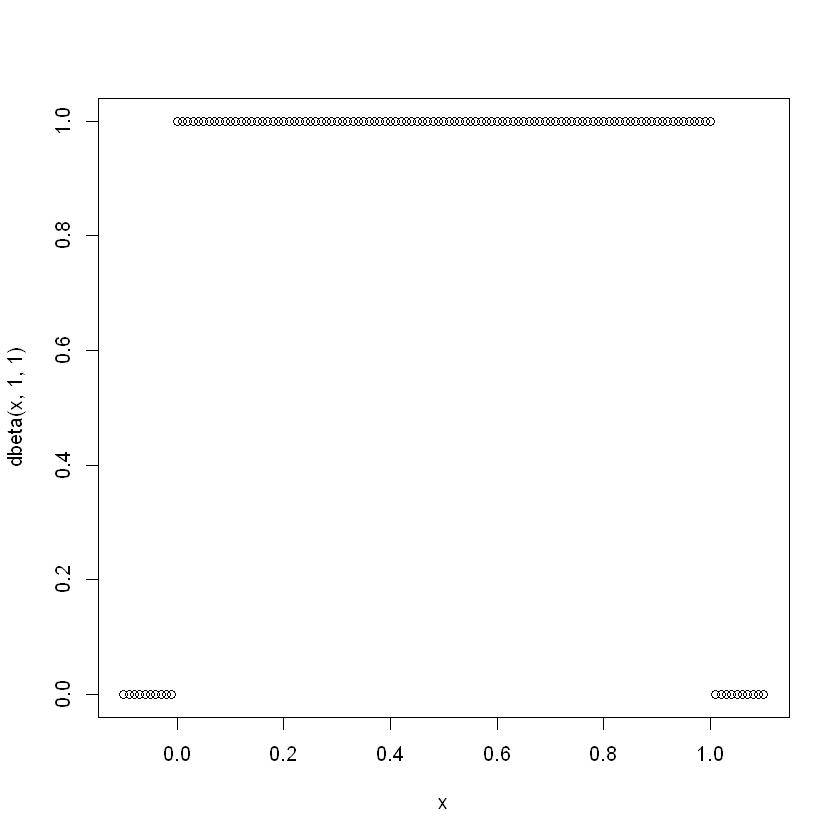

In [13]:
# Beta distribution
x = seq(-0.1, 1.1, 0.01)
plot(x, dbeta(x, 1, 1))

In [35]:
# Import the required libraries
library(ggplot2)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=10, repr.plot.height=6)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



## Single node network

In [39]:
# Generate the samples
theta = rbeta(1, 1, 1)
cat(theta)

n_samples = 10
samples = rbinom(n_samples, 1, theta)
samples

0.7281509

[1] 0 1 0 0 0 1 1 1 1 1

In [40]:
# Maximum likelihood theta
sum(samples) / length(samples)

[1] 0.6

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10
   Unobserved stochastic nodes: 1
   Total graph size: 14

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
theta,0.58,0.14,0.31,0.59,0.83,NA,20000


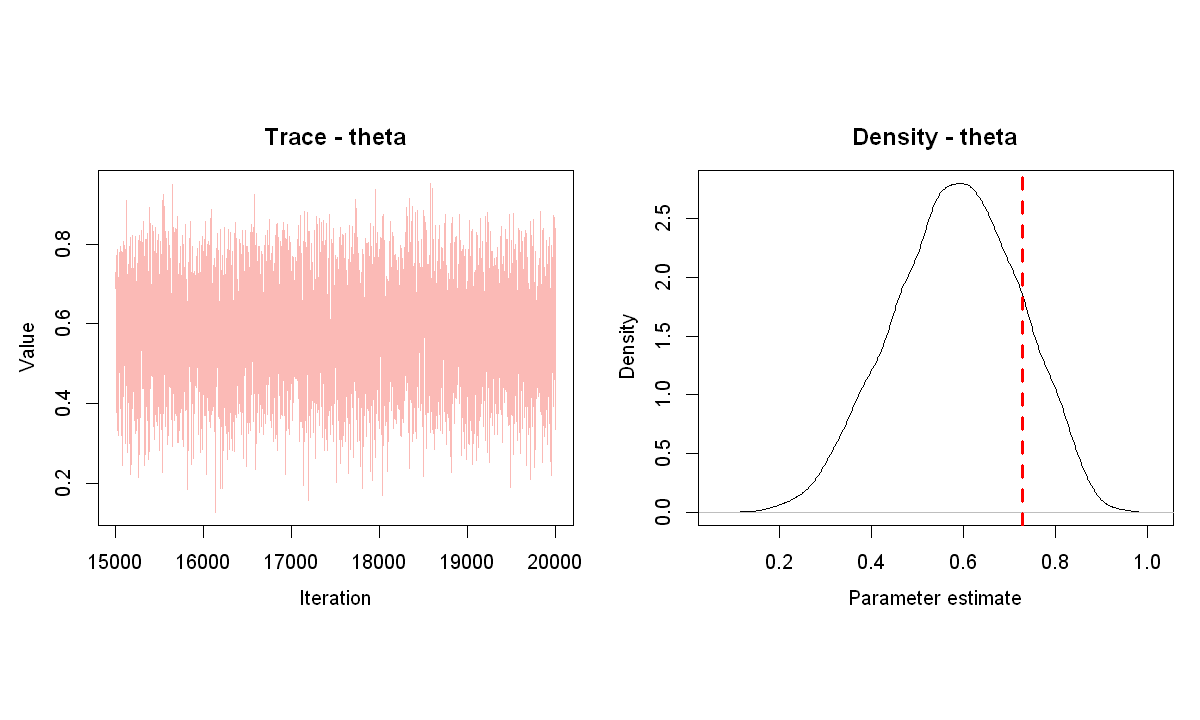

In [41]:
model_string = "
model {
    # Prior
    theta ~ dbeta(a, b)  # probability of a 1 appearing

    # Likelihood
    for (i in 1:N) {
        y[i] ~ dbern(theta)
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(y=samples, N=length(samples), a=1, b=1))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("theta"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          gv=theta,
          pdf=FALSE)

## Two node network

Learn the prior and CPT from a set of 'cases'.

In [106]:
# Generate the samples
n_samples = 100

theta = rbeta(3, 1, 1)

# Parent node
v = rbinom(n_samples, 1, theta[1])  # p(v=1) = 1-theta[1]

# Child node
c = rep(NA, n_samples)
for (i in 1:n_samples) {
    if (v[i] == 0) {
        c[i] = rbinom(1, 1, theta[2])
    } else {
        c[i] = rbinom(1, 1, theta[3])
    }
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 200
   Unobserved stochastic nodes: 3
   Total graph size: 207

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
theta1,0.04,0.02,0.01,0.04,0.08,NA,19742
theta2,0.78,0.04,0.69,0.78,0.85,NA,11500
theta3,0.60,0.20,0.19,0.62,0.93,NA,12738


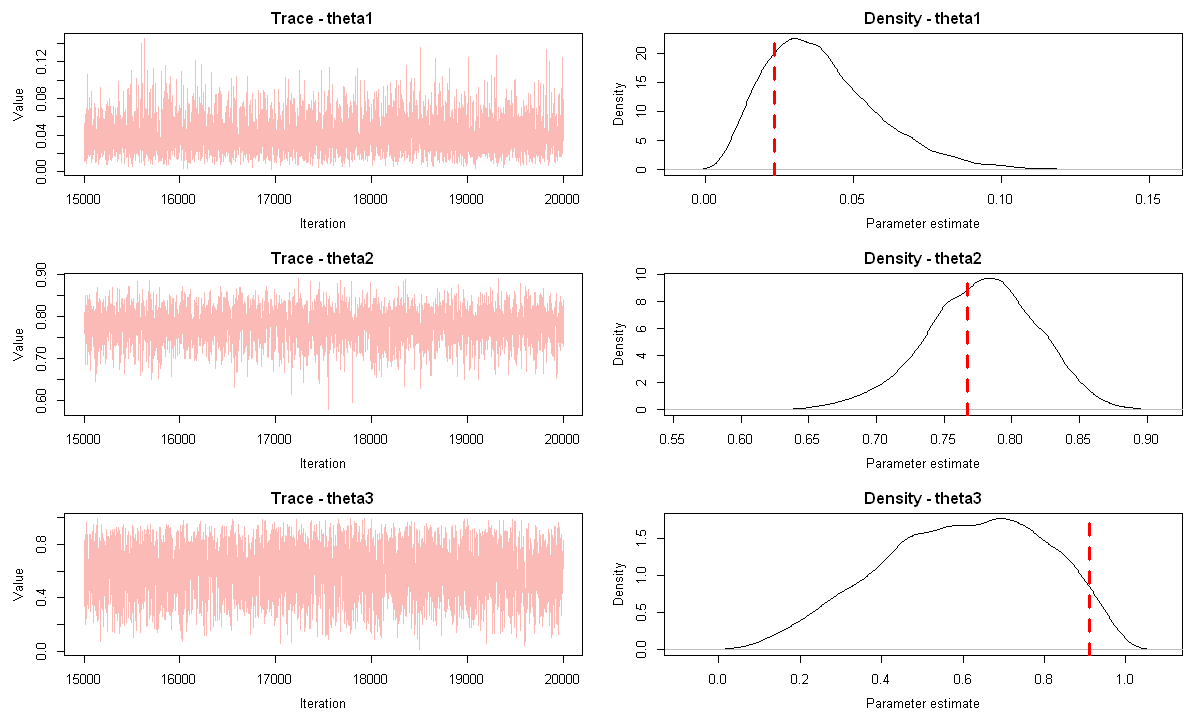

In [107]:
# Trained using data for v and c

model_string = "
model {
    # Node v
    theta1 ~ dbeta(a, b)  # probability of a 1 appearing in the 'v' node

    # CPT
    theta2 ~ dbeta(a, b)  # v == 0
    theta3 ~ dbeta(a, b)  # v == 1
    cpt[1] = theta2
    cpt[2] = theta3

    # Likelihood
    for (i in 1:N) {
        v[i] ~ dbern(theta1)
        c[i] ~ dbinom(cpt[v[i] + 1], 1)
    }
}
"

data = list(v=v, c=c, N=n_samples, a=1, b=1)

model = jags.model(textConnection(model_string),
                   data = data)

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("theta1", "theta2", "theta3"), 
                     n.iter=20000, 
                     progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          gv=theta,
          pdf=FALSE)

In [108]:
theta

[1] 0.02344797 0.76720251 0.91150536

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 103
   Total graph size: 407

Initializing model



Warning message in MCMCsummary(samp, round = 2):
"Rhat statistic cannot be calculated with one chain. NAs inserted."


,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
theta1,0.48,0.29,0.02,0.45,0.96,NA,155
theta2,0.73,0.21,0.15,0.79,0.98,NA,342
theta3,0.67,0.23,0.09,0.75,0.98,NA,474


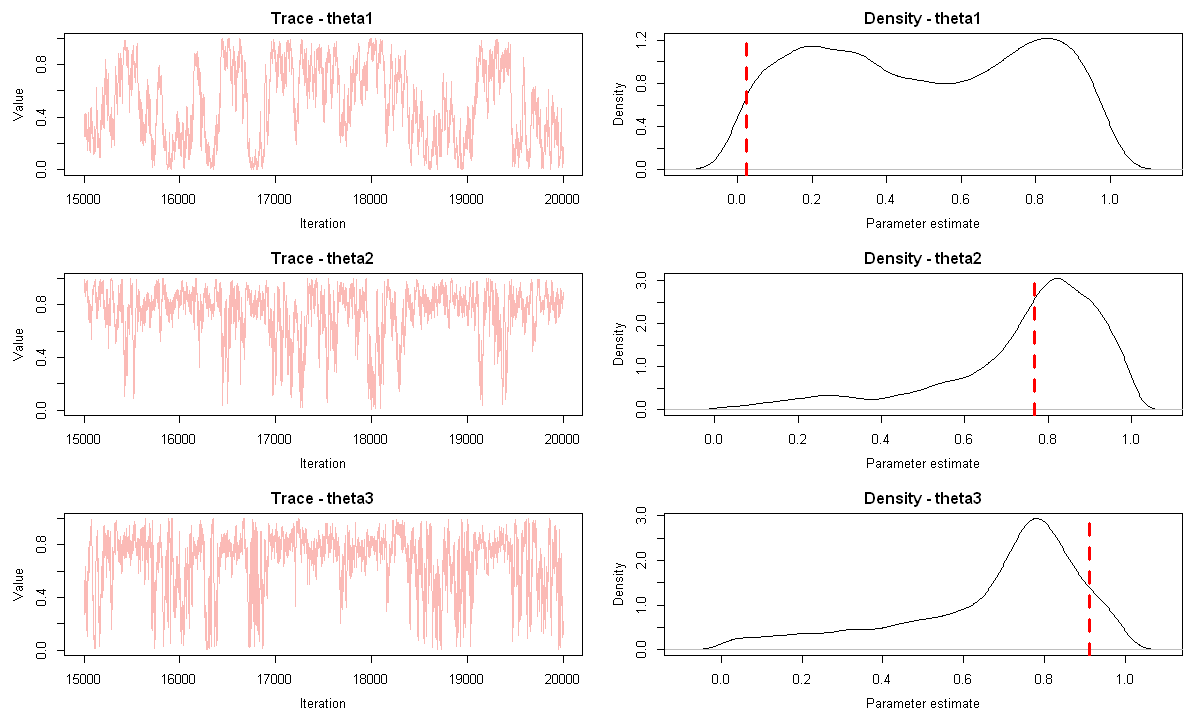

In [109]:
# Trained using data for c only (v has to be inferred)

model_string = "
model {
    # Node v
    theta1 ~ dbeta(a, b)  # probability of a 1 appearing in the 'v' node

    # CPT
    theta2 ~ dbeta(a, b)  # v == 0
    theta3 ~ dbeta(a, b)  # v == 1
    cpt[1] = theta2
    cpt[2] = theta3

    # Likelihood
    for (i in 1:N) {
        v[i] ~ dbern(theta1)
        c[i] ~ dbinom(cpt[v[i] + 1], 1)
    }
}
"

data = list(c=c, N=n_samples, a=1, b=1)

model = jags.model(textConnection(model_string),
                   data = data)

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("theta1", "theta2", "theta3"), 
                     n.iter=20000, 
                     progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          gv=theta,
          pdf=FALSE)

More difficult to infer parameters (larger variance) when only $c$ is provided.

## Learn parameters of 1 node network by ordering result

* Strict ordering

In [ ]:
model_string = "
model {
    # Prior
    theta ~ dbeta(a, b)  # probability of a 1 appearing

    # Likelihood
    for (i in 1:N) {
        y[i] ~ dbern(theta)
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(y=samples, N=length(samples), a=1, b=1))

update(model, 10000, progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("theta"), 
                     n.iter=20000, progress.bar="none")

# Show a summary of the variables
MCMCsummary(samp, round = 2)

MCMCtrace(samp, 
          gv=theta,
          pdf=FALSE)